<a href="https://colab.research.google.com/github/microsoft/autogen/blob/main/notebook/agentchat_auto_feedback_from_code_execution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Auto Generated Agent Chat: Task Solving with Code Generation, Execution & Debugging

AutoGen offers conversable LLM agents, which can be used to solve various tasks with human or automatic feedback, including tasks that require using tools via code.
Please find documentation about this feature [here](https://microsoft.github.io/autogen/docs/Use-Cases/agent_chat).

In this notebook, we demonstrate how to use `AssistantAgent` and `UserProxyAgent` to write code and execute the code. Here `AssistantAgent` is an LLM-based agent that can write Python code (in a Python coding block) for a user to execute for a given task. `UserProxyAgent` is an agent which serves as a proxy for the human user to execute the code written by `AssistantAgent`, or automatically execute the code. Depending on the setting of `human_input_mode` and `max_consecutive_auto_reply`, the `UserProxyAgent` either solicits feedback from the human user or returns auto-feedback based on the result of code execution (success or failure and corresponding outputs) to `AssistantAgent`. `AssistantAgent` will debug the code and suggest new code if the result contains error. The two agents keep communicating to each other until the task is done.

## Requirements

AutoGen requires `Python>=3.8`. To run this notebook example, please install:
```bash
pip install pyautogen
```

In [7]:
# %pip install pyautogen~=0.1.0

## Set your API Endpoint

The [`config_list_from_json`](https://microsoft.github.io/autogen/docs/reference/oai/openai_utils#config_list_from_json) function loads a list of configurations from an environment variable or a json file.


In [8]:
import autogen
import os

config_list = [
    {
        "model": "gpt-35-turbo-16k",
        'api_key': os.environ.get("AZURE_OPENAI_API_KEY"),
        'api_base': os.environ.get("AZURE_OPENAI_ENDPOINT"),
        'api_type': 'azure',
        'api_version': '2023-05-15',
    },  
]

## Example Task: Check Stock Price Change

In the example below, let's see how to use the agents in AutoGen to write a python script and execute the script. This process involves constructing a `AssistantAgent` to serve as the assistant, along with a `UserProxyAgent` that acts as a proxy for the human user. In this example demonstrated below, when constructing the `UserProxyAgent`,  we select the `human_input_mode` to "NEVER". This means that the `UserProxyAgent` will not solicit feedback from the human user. It stops replying when the limit defined by `max_consecutive_auto_reply` is reached, or when `is_termination_msg()` returns true for the received message.

In [9]:
# create an AssistantAgent named "assistant"
assistant = autogen.AssistantAgent(
    name="assistant",
    llm_config={
        "seed": 42,  # seed for caching and reproducibility
        "config_list": config_list,  # a list of OpenAI API configurations
        "temperature": 0,  # temperature for sampling
    },  # configuration for autogen's enhanced inference API which is compatible with OpenAI API
)
# create a UserProxyAgent instance named "user_proxy"
user_proxy = autogen.UserProxyAgent(
    name="user_proxy",
    human_input_mode="NEVER",
    max_consecutive_auto_reply=10,
    is_termination_msg=lambda x: x.get("content", "").rstrip().endswith("TERMINATE"),
    code_execution_config={
        "work_dir": "coding",
        "use_docker": False,  # set to True or image name like "python:3" to use docker
    },
)
# the assistant receives a message from the user_proxy, which contains the task description
user_proxy.initiate_chat(
    assistant,
    message="""What is the date is today? Compare the year-to-date gain for META and TESLA.""",
)

user_proxy (to assistant):

What is the date is today? Compare the year-to-date gain for META and TESLA.

--------------------------------------------------------------------------------
assistant (to user_proxy):

To get the current date, you can use the `datetime` module in Python. Here's the code to get the current date:

```python
import datetime

current_date = datetime.date.today()
print(current_date)
```

To compare the year-to-date gain for META and TESLA, we need historical stock price data for both companies. We can use a financial data API like Alpha Vantage to retrieve the historical stock prices. However, I need to know the specific date range for the year-to-date gain calculation and the API key for Alpha Vantage. Could you please provide those details?

--------------------------------------------------------------------------------

>>>>>>>> EXECUTING CODE BLOCK 0 (inferred language is python)...
user_proxy (to assistant):

exitcode: 0 (execution succeeded)
Code output:

The example above involves code execution. In AutoGen, code execution is triggered automatically by the `UserProxyAgent` when it detects an executable code block in a received message and no human user input is provided. This process occurs in a designated working directory, using a Docker container by default. Unless a specific directory is specified, AutoGen defaults to the `autogen/extensions` directory. Users have the option to specify a different working directory by setting the `work_dir` argument when constructing a new instance of the `UserProxyAgent`.

The whole chat is auto generated.

## Example Task: Plot Chart

In [10]:
# followup of the previous question
user_proxy.send(
    recipient=assistant,
    message="""Plot a chart of their stock price change YTD and save to stock_price_ytd.png.""",
)

user_proxy (to assistant):

Plot a chart of their stock price change YTD and save to stock_price_ytd.png.

--------------------------------------------------------------------------------
assistant (to user_proxy):

To plot a chart of the stock price change year-to-date (YTD) for META and TESLA and save it as "stock_price_ytd.png", we can use the `matplotlib` library in Python. If you don't have it installed, you can install it using `pip install matplotlib`.

Here's the code to plot the chart and save it as an image:

```python
import yfinance as yf
import matplotlib.pyplot as plt
import datetime

# Define the ticker symbols for META and TESLA
meta_ticker = "META"
tesla_ticker = "TSLA"

# Get the current date
current_date = datetime.date.today()

# Get the historical stock prices for the year-to-date period
meta_data = yf.download(meta_ticker, start=f"{current_date.year}-01-01", end=current_date)
tesla_data = yf.download(tesla_ticker, start=f"{current_date.year}-01-01", end=current_da

Let's display the generated figure.

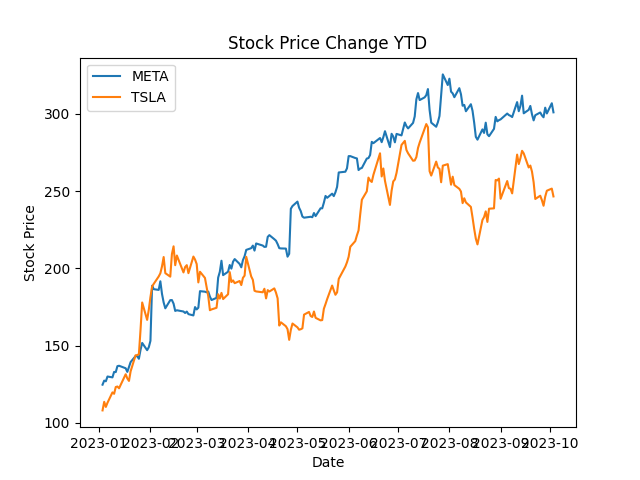

In [11]:
from IPython.display import Image

Image(filename='coding/stock_price_ytd.png')

## Use a Different Code Execution Environment

The code execution happened in a separate process, so the plot is not directly displayed in the notebook. Is it possible to change the code execution environment into IPython?

Yes! In the following we demonstrate how to extend the `UserProxyAgent` to use a different code execution environment.

In [12]:
from typing import Dict, Union
from IPython import get_ipython

class IPythonUserProxyAgent(autogen.UserProxyAgent):
    def __init__(self, name: str, **kwargs):
        super().__init__(name, **kwargs)
        self._ipython = get_ipython()

    def generate_init_message(self, *args, **kwargs) -> Union[str, Dict]:
        return super().generate_init_message(*args, **kwargs) + """
If you suggest code, the code will be executed in IPython."""

    def run_code(self, code, **kwargs):
        result = self._ipython.run_cell("%%capture --no-display cap\n" + code)
        log = self._ipython.ev("cap.stdout")
        log += self._ipython.ev("cap.stderr")
        if result.result is not None:
            log += str(result.result)
        exitcode = 0 if result.success else 1
        if result.error_before_exec is not None:
            log += f"\n{result.error_before_exec}"
            exitcode = 1
        if result.error_in_exec is not None:
            log += f"\n{result.error_in_exec}"
            exitcode = 1
        return exitcode, log, None

The implementation overrides three functions in `UserProxyAgent`:
* constructor. We get the ipython instance as the code execution environment.
* `generate_init_message`. We generate a modified initial message to send to the assistant agent, by adding the info that the execution will be performed in IPython.
* `run_code`. We execute the code with the ipython instance.

With the new `IPythonUserProxyAgent`, we are able to run the code within the current notebook environment and display plot directly.

ipython_user_proxy (to assistant):

Plot a chart of META and TESLA stock price gain YTD
If you suggest code, the code will be executed in IPython.

--------------------------------------------------------------------------------
assistant (to ipython_user_proxy):

To plot a chart of the stock price gain YTD for META and TESLA, we need to first collect the historical stock price data for both companies. We can use the yfinance library in Python to fetch the stock price data. Once we have the data, we can calculate the YTD gain and plot it using the matplotlib library.

Here is the Python code to accomplish this task:

```python
# filename: stock_price_gain.py
import yfinance as yf
import matplotlib.pyplot as plt

# Fetch the stock price data for META and TESLA
meta = yf.Ticker("META")
tesla = yf.Ticker("TSLA")

# Get the historical stock price data for the current year
meta_history = meta.history(period="YTD")
tesla_history = tesla.history(period="YTD")

# Calculate the YTD gain for MET

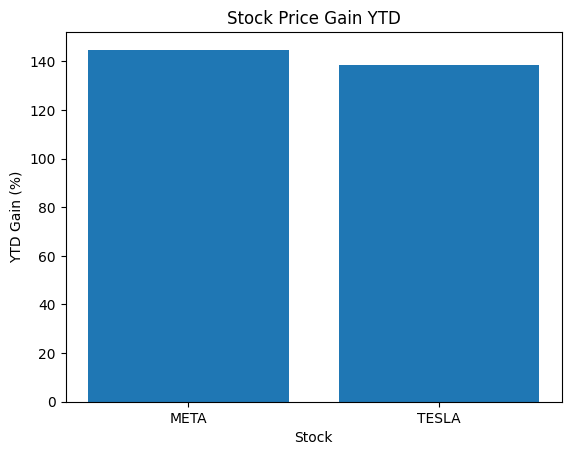


>>>>>>>> EXECUTING CODE BLOCK 1 (inferred language is unknown)...
ipython_user_proxy (to assistant):

exitcode: 1 (execution failed)
Code output: 
/tmp/ipykernel_6965/2800554485.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  meta_gain = (meta_history["Close"][-1] - meta_history["Close"][0]) / meta_history["Close"][0] * 100
/tmp/ipykernel_6965/2800554485.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  tesla_gain = (tesla_history["Close"][-1] - tesla_history["Close"][0]) / tesla_history["Close"][0] * 100

unknown language unknown

-----------------------------------------------------------------------------

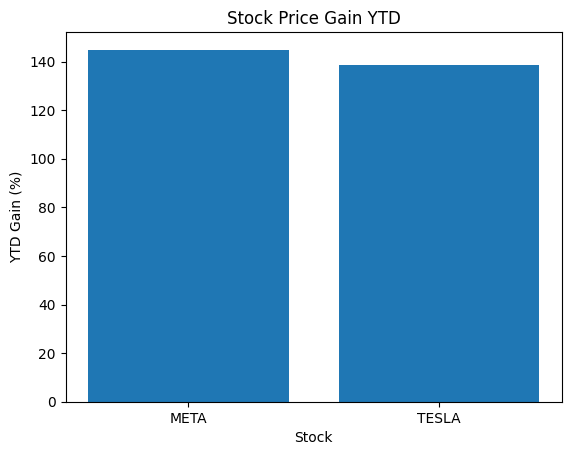

ipython_user_proxy (to assistant):

exitcode: 0 (execution succeeded)
Code output: 


--------------------------------------------------------------------------------
assistant (to ipython_user_proxy):

Great! I'm glad to hear that the code executed successfully without any errors. Now you should see a bar chart displaying the YTD gain for META and TESLA stocks.

If you have any further questions or need assistance with anything else, feel free to ask.

--------------------------------------------------------------------------------
ipython_user_proxy (to assistant):



--------------------------------------------------------------------------------
assistant (to ipython_user_proxy):

TERMINATE

--------------------------------------------------------------------------------


In [13]:
ipy_user = IPythonUserProxyAgent(
    "ipython_user_proxy",
    human_input_mode="NEVER",
    max_consecutive_auto_reply=10,
    is_termination_msg=lambda x: x.get("content", "").rstrip().endswith("TERMINATE") or x.get("content", "").rstrip().endswith('"TERMINATE".'),
)
# the assistant receives a message from the user, which contains the task description
ipy_user.initiate_chat(
    assistant,
    message="""Plot a chart of META and TESLA stock price gain YTD""",
)